# Generate Phase-only Hologram (Double Phase Amplitude Coding)
 
- Reference
1. <i>HSUEH, Chung-Kai; SAWCHUK, Alexander A. "Computer-generated double-phase holograms". Applied optics, 1978, 17.24: 3874-3883.</i>
2. <i>MAIMONE, Andrew; GEORGIOU, Andreas; KOLLIN, Joel S. "Holographic near-eye displays for virtual and augmented reality". ACM Transactions on Graphics (Tog), 2017, 36.4: 1-16.</i>
    - 3.1.3 Obtaining Amplitude → Direct Amplitude Encoding

3. <i>Tsang, P. W. M. (2021). Computer-Generated Phase-Only Holograms for 3D Displays: A Matlab Approach. Cambridge University Press.</i>

(3번 Reference에 관해서는 "VML-2022 > [Hologram] > 0.Book > (Book) 2021 Peter CGPOH for 3d displays > 4. Conversion-of-complex-valued-holograms-to-phase-only-holograms.pdf > 4.3 Double-Phase Macro-Pixel Hologram" 참고)

<br/>

#### <b>Double Phase Method</b>
Phase-only hologram을 생성하는 한 가지 방법은 **<u>Amplitude와 Phase를 두 개의 위상 값으로 명시적으로 인코딩하는 것</u>**이다. 이것은 double phase method로 알려져 있다. Amplitude $a (0 \le a \le 1)$와 위상 $p$를 가진 복소수 값 $c$는 두 값 $c=c_a+c_b$의 합으로 인코딩될 수 있으며, <u>각 값은 가변적인 위상을 가지지만, Amplitude는 일정하다</u>.


- $c=ae^{ip}$ 
- $c_a=\frac{1}{2}e^{ip_a} (p_a = p+\cos^{-1}a)$ 
- $c_b=\frac{1}{2}e^{ip_b} (p_b = p-\cos^{-1}a)$ 

→ $c_a + c_b = \frac{1}{2}[e^{i(p+\cos^{-1}a)} + e^{i(p-\cos^{-1}a)}]$<br/>
　　 　　　$= \frac{1}{2}[\cos(p-\cos^{-1}a)+i\sin(p-\cos^{-1}a) + \cos(p+\cos^{-1}a)+i\sin(p+\cos^{-1}a)]$<br/>
　　 　　　$= \cos p\cos(\cos^{-1}a) + i\sin p\cos(\cos^{-1}a)$<br/>
　　 　　　$= a\cos p+ia\sin p = ae^{ip} = c$<br/>

<br/>

<center>
<p>
    <img src="double_phase_method.gif" width=200>

    Fig 1. How the Double Phase Method works in complex plane
</p>
</center>

<br/>

#### <b>Double Phase Amplitude Coding (DPAC)</b>
그러나, 디스플레이는 두 개의 위상 값을 하나의 복소수 값으로 물리적으로 통합할 수 있어야 한다. <u>SLM에서 위의 방정식에 따라 계산된 인접한 쌍의 위상 값을 checkerboard 패턴으로 배치함으로써</u>, 우리는 암묵적으로 높은 주파수의 회절격자(high frequency grating)를 생성하여 원하지 않는 에너지를 exit pupil의 가장자리로 밀어낸다. 이 direct method의 이점은 <u>초기 복소수 값의 홀로그램 $H$가 얻어진 후 인코딩이 매우 간단하며 반복 또는 최적화가 필요하지 않다</u>는 점이다.

In [ ]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
cm, mm, um, nm = 1e-2, 1e-3, 1e-6, 1e-9

In [2]:
def pad_image(field, target_shape, padval=0, mode='constant'):
    """
        Pads a 2D complex field up to target_shape in size
        Padding is done such that when used with crop_image(), odd and even dimensions are handled correctly to properly undo the padding.

        field:          the field to be padded. May have as many leading dimensions as necessary (e.g., batch or channel dimensions)
        target_shape:   the 2D target output dimensions. If any dimensions are smaller than field, no padding is applied
        padval:         the real number value to pad by (default: 0)
        mode:           padding mode for numpy or torch
    """
    size_diff = np.array(target_shape) - np.array(field.shape[-2:])
    odd_dim = np.array(field.shape[-2:]) % 2

    # pad the dimensions that need to increase in size
    if (size_diff > 0).any():
        pad_total = np.maximum(size_diff, 0)
        pad_front = (pad_total + odd_dim) // 2
        pad_end = (pad_total + 1 - odd_dim) // 2

        leading_dims = field.ndim - 2  # only pad the last two dims
        if leading_dims > 0:
            pad_front = np.concatenate(([0] * leading_dims, pad_front))
            pad_end = np.concatenate(([0] * leading_dims, pad_end))
        return np.pad(field, tuple(zip(pad_front, pad_end)), mode, constant_values=padval)

    else:
        return field


In [3]:

def crop_image(field, target_shape):
    """
        Crops a 2D field, see pad_image() for detail
        No cropping is done if target_shape is already smaller than field
    """
    if target_shape is None:
        return field

    size_diff = np.array(field.shape[-2:]) - np.array(target_shape)
    odd_dim = np.array(field.shape[-2:]) % 2

    # crop dimensions that need to decrease in size
    if (size_diff > 0).any():
        crop_total = np.maximum(size_diff, 0)
        crop_front = (crop_total + 1 - odd_dim) // 2
        crop_end = (crop_total + odd_dim) // 2

        crop_slices = [slice(int(f), int(-e) if e else None) for f, e in zip(crop_front, crop_end)]
        return field[(..., *crop_slices)]
    else:
        return field

# 1. Make aperture at image plane (z=0)

$z_0$ 위치에서 Source plane (aperture) 생성. 이때, 단순한 binary 함수가 아닌, 다음의 수식을 통해 aperture를 생성한다.

$g(x, y;z_0)=\exp^{[-(\frac{\sqrt{x^2+y^2}}{D/2})^{50}]}$.

Source plane에서 $x$축, $y$축에 대한 표본화 간격 및 표본화 개수는 각각 10㎛, 1000을 따르며, aperture의 크기 $D=1$㎜로 설정한다.

- sampling interval: 10㎛
- the # of sample points: 1000
- source plane size: 10㎛ * 1000 = 10㎜
- aperture size: 1㎜


In [4]:
def source_field(image_size, aperture_size, sampling_interval, num_samples):

    # Grid Coordinate
    x_point = np.linspace(-image_size/2, image_size/2 - sampling_interval, num=num_samples)
    y_point = np.linspace(-image_size/2, image_size/2 - sampling_interval, num=num_samples)
    grid_x, grid_y = np.meshgrid(x_point, y_point)

    # Aperture
    aperture = np.sqrt((grid_x ** 2) + (grid_y ** 2)) / (aperture_size / 2)
    aperture = np.exp(-np.power(aperture, 50))
    return aperture

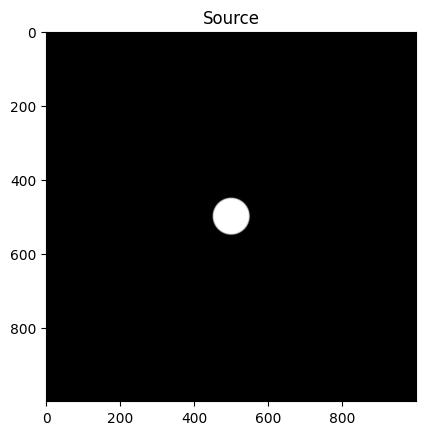

In [5]:
num_samples = 1000
sampling_interval = 10 * um
image_size = num_samples * sampling_interval
aperture_size = 1 * mm

# Make aperture at image plane (z=0)
source = source_field(image_size, aperture_size, sampling_interval, num_samples)

plt.imshow(source, cmap="gray")
plt.title("Source")
plt.show()

# 2. Band-limited Angular Spectrum Method (BL-ASM)

Band-Limited Angular Spectrum Method를 통해 $z_0$에 위치한 source를 $d$만큼 떨어진 거리의 destination field로 전파하는 방법은 다음과 같다.

$g[m, n; z] = FFT^{-1}[FFT[g[m, n; z_0]] \times H_{BLAS}[p, q; d]]$

1. $z_0$에 위치한 Image domain의 source plane을 Fourier Transform 한다.
2. Fourier domain에서 source plane을 $d$만큼 전파할 Transfer function (kernel)을 계산한다.
3. 1의 결과와 2의 결과를 곱한다. (Convolution in image domain)
4. 3의 결과에 inverse Fourier Transform 연산을 수행한다.


이때, Fourier domain에서의 transfer function $H$는 다음과 같이 계산할 수 있다.

$H_{BLAS}[p, q; d] = \begin{cases} \exp[i2\pi d(\lambda^{-2}-u_p^2-v_q^2)] rect(\frac{u_p}{2u_{BL}})rect(\frac{v_q}{2v_{BL}}) &\text{if } u_p^2+v_q^2\le\lambda^{-2}\\ 0 & \text{otherwise}  \end{cases}$



In [6]:
def propagation_blasm(u_in, feature_size, wave_length, z, sampling=1, linear_conv=True):
    """
        Propagates the input field using the angular spectrum method

        Inputs
        ------
        u_in:           input complex numpy array 
        feature_size:   (height, width) of individual holographic features in m
        wavelength:     wavelength in m
        z:              propagation distance
        sampling:       extended band-limited ASM, default 1
        linear_conv:    if True, pad the input to obtain a linear convolution, default True

        Output
        ------
        tensor of size (height, width)
    """

    # preprocess with (zero-)padding for linear convolution
    if linear_conv:
        input_resolution = u_in.shape[-2:]
        conv_size = [i * 2 for i in input_resolution]
        u_in = pad_image(u_in, conv_size, padval=0)

    field_resolution = u_in.shape[-2:]                          # Resolution of input field
    num_y, num_x = field_resolution[-2], field_resolution[-1]   # Number of pixels
    dy, dx = feature_size                                       # Sampling interval
    y, x = (dy * float(num_y), dx * float(num_x))               # Size of the input / slm field

    # frequency coordinates sampling
    fy = np.linspace(-1 / (2 * dy), 1 / (2 * dy), num_y)
    fx = np.linspace(-1 / (2 * dx), 1 / (2 * dx), num_x)
    fxx, fyy = np.meshgrid(fx, fy)

    # calculate transfer function (ASM)
    kernel = np.exp(1j * 2 * np.pi * z * np.sqrt(1 / wave_length**2 - (fxx**2 + fyy**2)))

    # calculate band-limited transfer function (BL-ASM)
    dv, du = 1 / (num_y * dy), 1 / (num_x * dx)
    bly = 1 / (wave_length * np.sqrt((2 * z * dv)**2 + 1))
    blx = 1 / (wave_length * np.sqrt((2 * z * du)**2 + 1))
    bl_filter = (np.abs(fxx) < blx) & (np.abs(fyy) < bly)
    bl_kernel = bl_filter * kernel

    # propagate source (aperture) to destination field
    u_out = fft.fftshift(fft.fftn(fft.fftshift(u_in), axes=(-2, -1)))     
    u_out = bl_kernel * u_out                                             
    u_out = fft.fftshift(fft.ifftn(fft.fftshift(u_out), axes=(-2, -1)))   
    
    if linear_conv:
        u_out = crop_image(u_out, input_resolution)

    return u_out

# 3. Make Full Complex Hologram
앞서 정의한 Propagation method를 통해 $d$만큼 떨어진 위치에서 complex hologram을 계산한다.

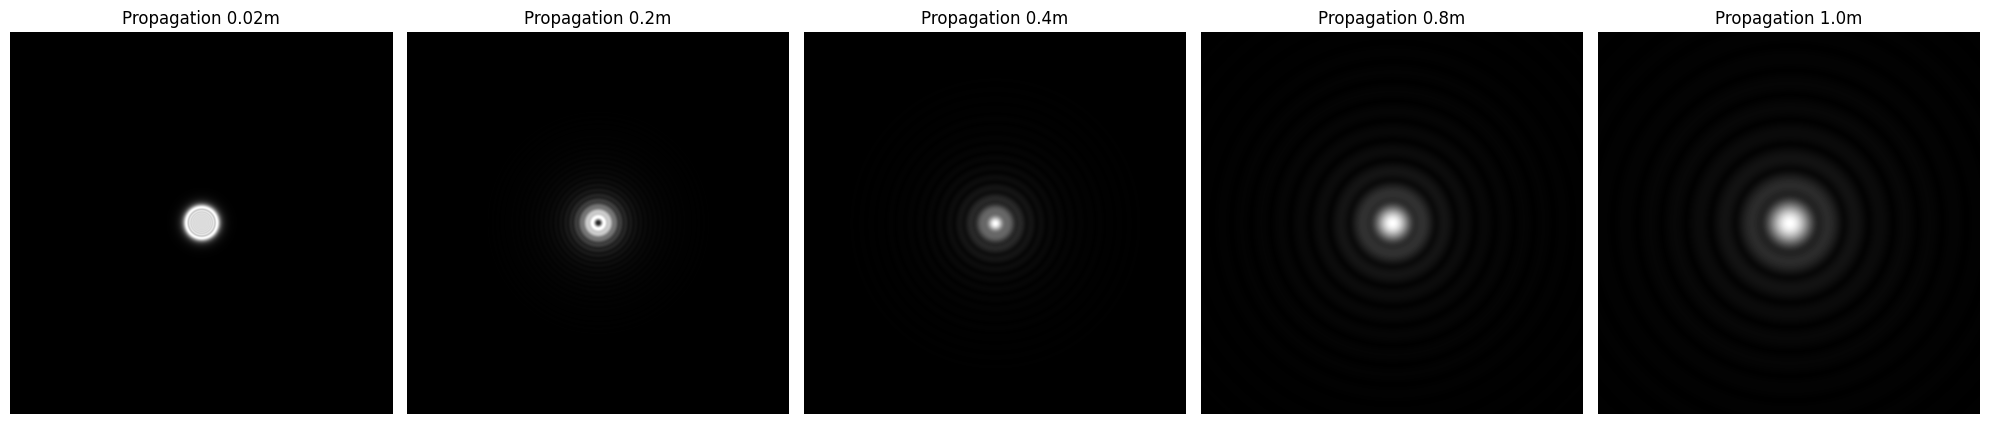

In [7]:
# fixed
source = source * np.exp(1j * np.zeros_like(source))
feature_size = (10 * um, 10 * um)

# experiment
wave_length = 633 * nm       
prop_dist = [2 * cm, 20 * cm, 40 * cm, 80 * cm, 100 * cm]
visualization_title = [f'Propagation {z}m' for z in prop_dist]

image_to_slm = []       # The list of full-complex hologram
for z in prop_dist:
    image_to_slm.append(
        propagation_blasm(source, feature_size, wave_length, z)
    )

plt.figure(figsize=(20, 20))
for i, hologram in enumerate(image_to_slm):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(np.abs(hologram), cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# 4. Double Phase-Amplitude Coding (DPAC)

DPAC algorithm을 이용해 위상 홀로그램을 생성한다. 생성하는 방법은 다음과 같다.

1. source plane에 위치한 aperture를 destination plane으로 propagation 한다.
2. Destination plane의 complex hologram을 amplitude(normalized)와 angle로 분해한다.
3. Double Phase Method에 따라 2개의 위상으로 분해한다.
4. Checkerboard pattern으로 배치하여 위상 홀로그램을 생성한다.

In [21]:
def double_phase_amplitude_coding(full_complex_hologram):
    # Normalize Amplitude
    amp = np.abs(full_complex_hologram)
    amp = amp / np.amax(amp)
    angle = np.angle(full_complex_hologram)
    
    # Double Phase Method
    phase_a = angle - np.arccos(amp)
    phase_b = angle + np.arccos(amp)
    
    # Checkerboard-like pattern
    phase_out = phase_a.copy()
    phase_out[::2, 1::2] = phase_b[::2, 1::2]
    phase_out[1::2, ::2] = phase_b[1::2, ::2]
    return phase_out, phase_a, phase_b

In [22]:
dpac_pohs = []
phase_as = []
phase_bs = []
amps = []
for hologram in image_to_slm:
    dpac_poh, phase_a, phase_b = double_phase_amplitude_coding(hologram)

    dpac_pohs.append(dpac_poh)
    phase_as.append(phase_a)
    phase_bs.append(phase_b)

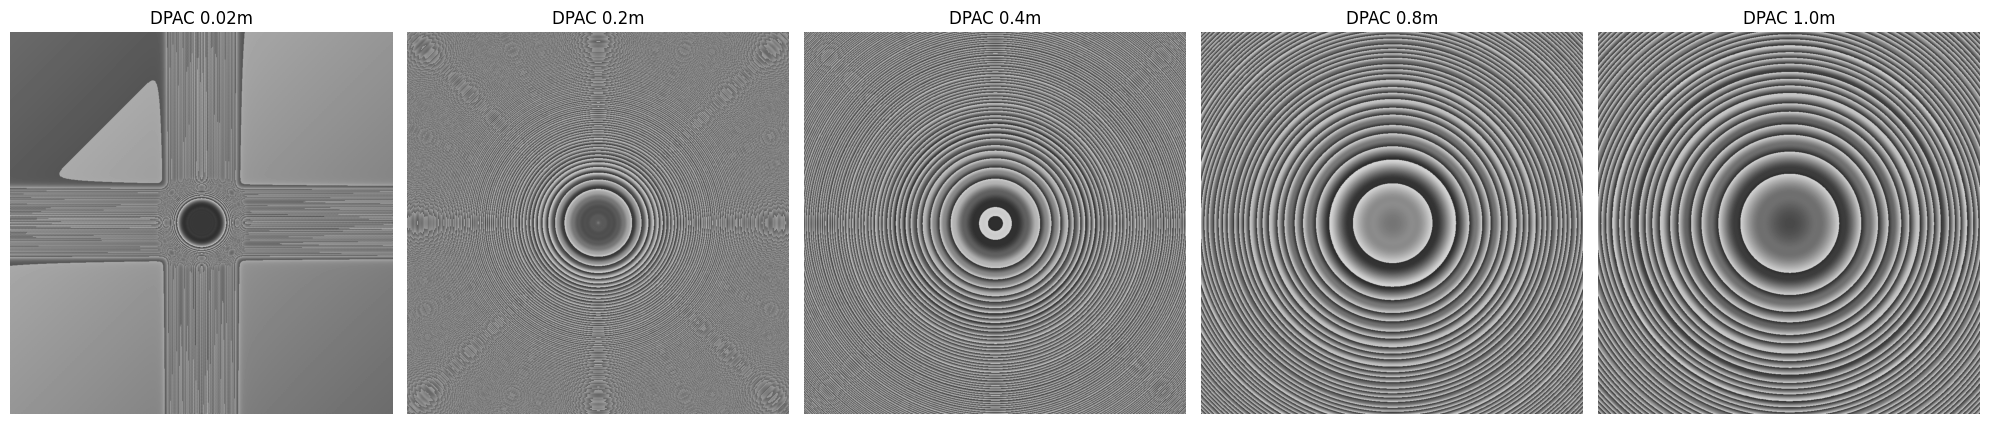

In [23]:
visualization_title = [f'DPAC {z}m' for z in prop_dist]

plt.figure(figsize=(20, 20))
for i, dpac_poh in enumerate(dpac_pohs):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(dpac_poh, cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

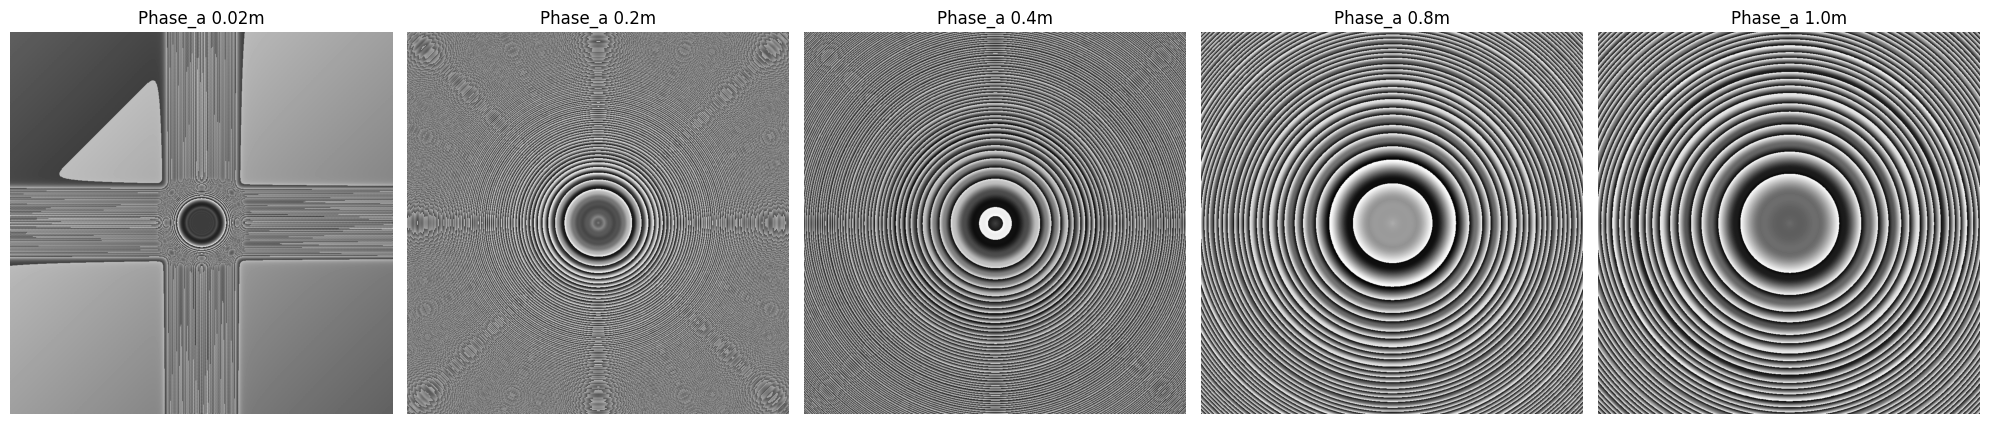

In [24]:
visualization_title = [f'Phase_a {z}m' for z in prop_dist]

plt.figure(figsize=(20, 20))
for i, phase_a in enumerate(phase_as):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(phase_a, cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

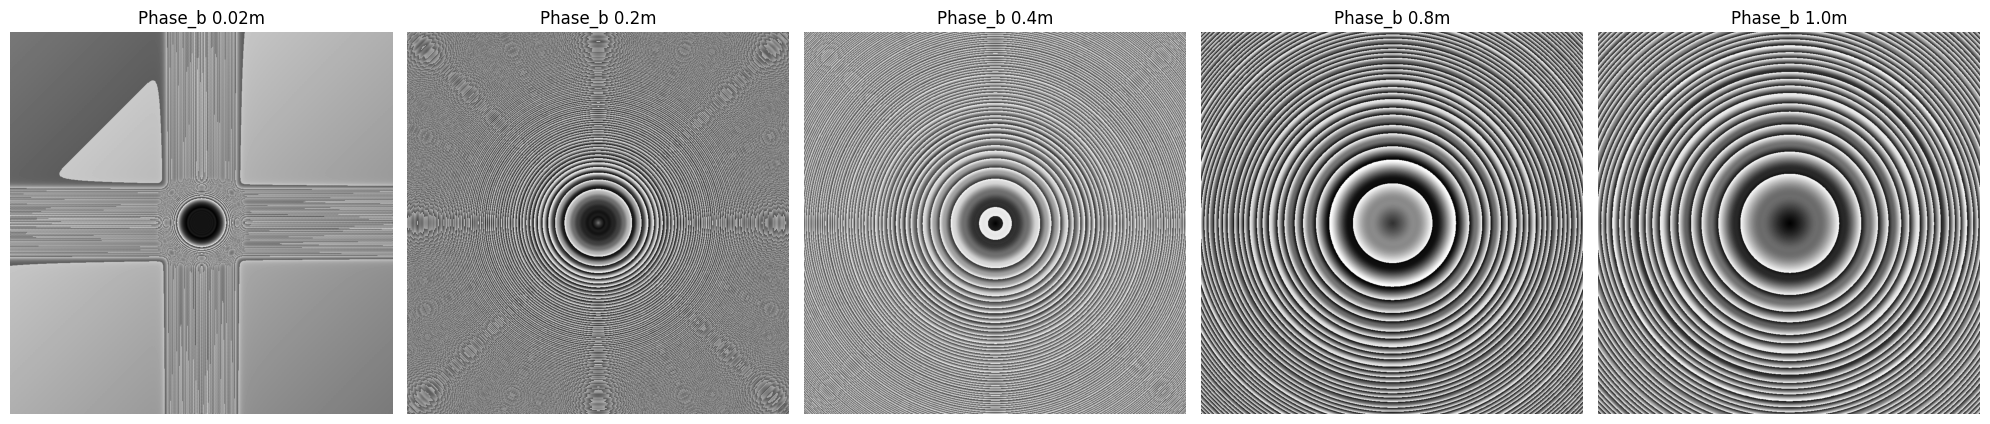

In [25]:
visualization_title = [f'Phase_b {z}m' for z in prop_dist]

plt.figure(figsize=(20, 20))
for i, phase_b in enumerate(phase_bs):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(phase_b, cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# 5. Reconstruction

### 5-1. Visualize Numerical Reconstruction of Full-complex Hologram

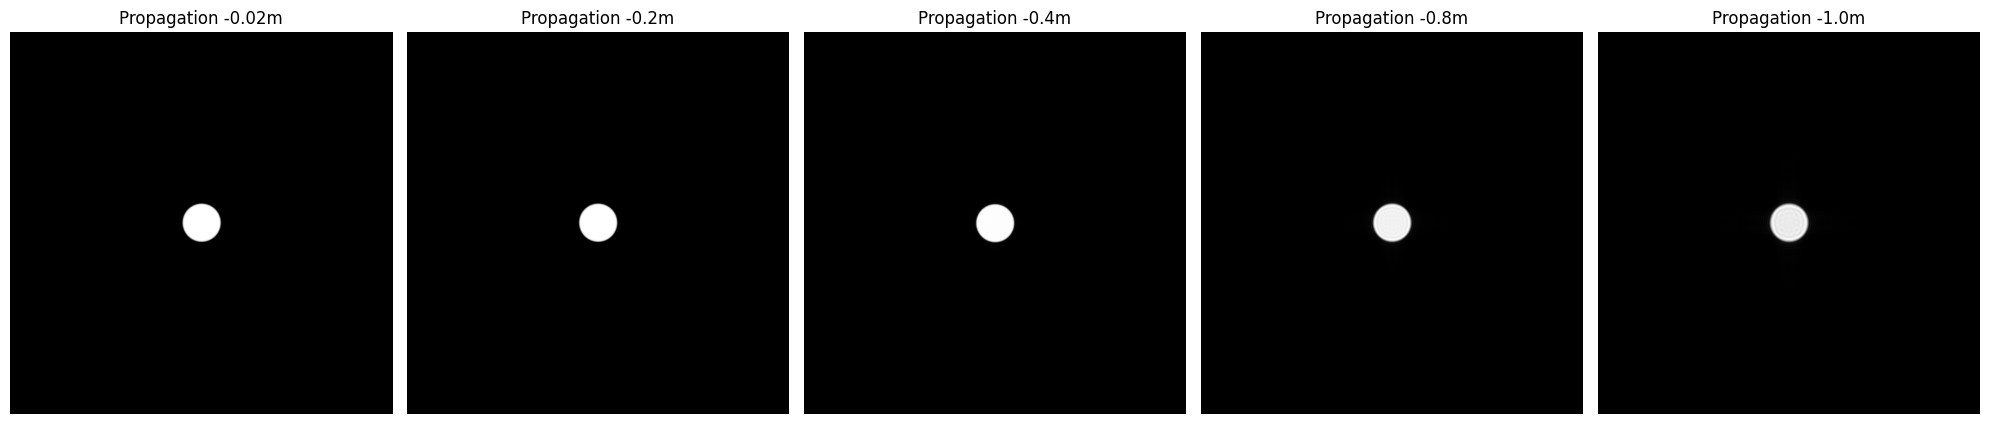

In [26]:
visualization_title = [f'Propagation -{z}m' for z in prop_dist]

slm_to_image_1 = []
for z, hologram in zip(prop_dist, image_to_slm):
    recon = propagation_blasm(hologram, feature_size, wave_length, -z)
    
    recon = np.abs(recon)
    recon = (recon - np.amin(recon)) / (np.amax(recon) - np.amin(recon))
    slm_to_image_1.append(recon)

plt.figure(figsize=(20, 20))
for i, image in enumerate(slm_to_image_1):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

### 5-2. Visualize Numerical Reconstruction of Double Phase Method

Note: Double Phase Method를 통해 얻은 Phase-only Hologram은 위상을 표현하는 실수값을 의미한다. 따라서 이를 Phase-only hologram 처럼 표현하기 위해선 $e^{ip}$ 형태로 변환해주어야 한다.

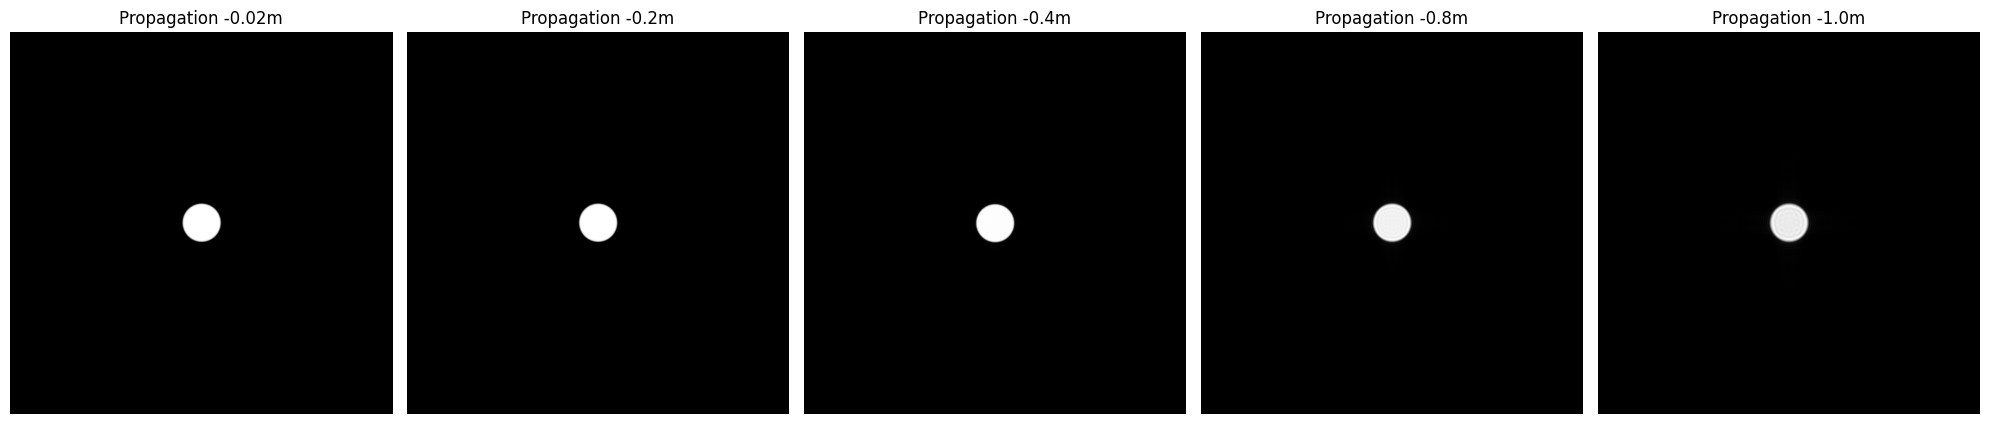

In [27]:
visualization_title = [f'Propagation -{z}m' for z in prop_dist]

slm_to_image_2 = []
for z, phase_a, phase_b in zip(prop_dist, phase_as, phase_bs):
    recon_1 = propagation_blasm(0.5 * np.exp(1j * phase_a), feature_size, wave_length, -z)
    recon_2 = propagation_blasm(0.5 * np.exp(1j * phase_b), feature_size, wave_length, -z)
    recon = recon_1 + recon_2 
    
    recon = np.abs(recon)
    recon = (recon - np.amin(recon)) / (np.amax(recon) - np.amin(recon))
    slm_to_image_2.append(recon)

plt.figure(figsize=(20, 20))
for i, image in enumerate(slm_to_image_2):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

### 5-3. Visualize Numerical Reconstruction of Double Phase-Amplitude Coding

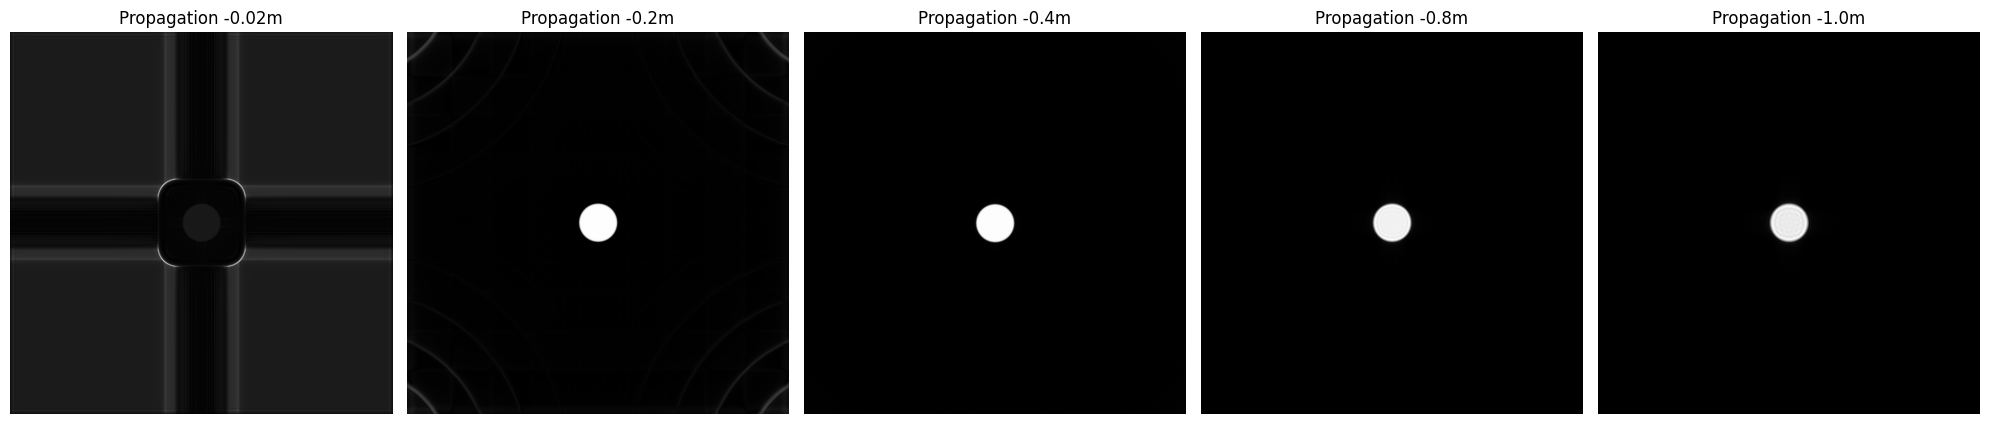

In [28]:
visualization_title = [f'Propagation -{z}m' for z in prop_dist]

slm_to_image_3 = []
for z, dpac_poh in zip(prop_dist, dpac_pohs):
    recon = propagation_blasm(np.exp(1j * dpac_poh), feature_size, wave_length, -z)

    recon = np.abs(recon)
    recon = (recon - np.amin(recon)) / (np.amax(recon) - np.amin(recon))
    slm_to_image_3.append(recon)

plt.figure(figsize=(20, 20))
for i, image in enumerate(slm_to_image_3):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# 6. Objective Quality Metrics


In [29]:
def peak_signal_noise_ratio(target, output):
    mse = np.mean((target - output) ** 2)
    psnr = 20 * np.log10(1.0 / np.sqrt(mse))
    return psnr

In [30]:
source = np.abs(source)

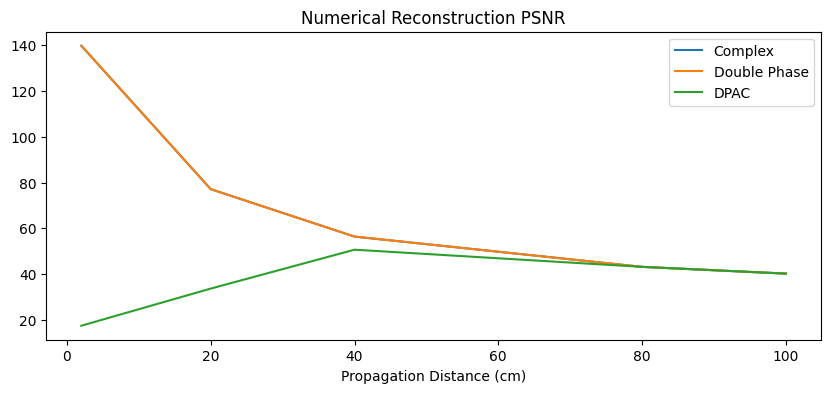

In [31]:
psnrs = []

for image1, image2, image3 in zip(slm_to_image_1, slm_to_image_2, slm_to_image_3):
    psnrs.append([
        peak_signal_noise_ratio(source, image1),
        peak_signal_noise_ratio(source, image2),
        peak_signal_noise_ratio(source, image3)
    ])

plt.figure(figsize=(10, 4))
plt.plot([z * 100 for z in prop_dist], psnrs)
plt.legend(('Complex', 'Double Phase', 'DPAC'))
plt.title('Numerical Reconstruction PSNR')
plt.xlabel('Propagation Distance (cm)')
plt.show()

In [33]:
psnrs

[[139.76483115108525, 139.76483115075322, 17.480303639810128],
 [77.13067016838937, 77.13067016838933, 33.70091055006414],
 [56.404683749960995, 56.40468374996075, 50.68253098793086],
 [43.18842725649234, 43.1884272564923, 43.18606280806564],
 [40.23603938170143, 40.23603938170141, 40.23568246463499]]

# 7. Discussion

# 8. 2D Image

In [ ]:
import skimage.io as sio
img = sio.imread('../assets/sample1.png')[:, :, 1] / 255.
plt.imshow(img, cmap='gray')
plt.show()

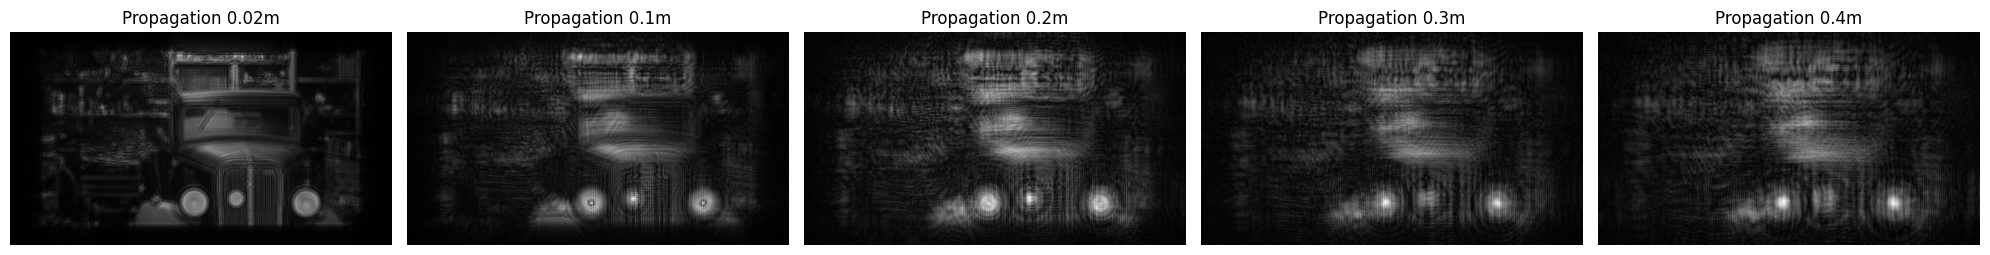

In [ ]:
# fixed
img = img * np.exp(1j * np.zeros_like(img))
feature_size = (6.4 * um, 6.4 * um)

# experiment
wave_length = 633 * nm
prop_dist = [2 * cm, 10 * cm, 20 * cm, 30 * cm, 40 * cm]
visualization_title = [f'Propagation {z}m' for z in prop_dist]

image_to_slm = []
for z in prop_dist:
    image_to_slm.append(
        propagation_blasm(img, feature_size, wave_length, z)
    )

plt.figure(figsize=(20, 20))
for i, hologram in enumerate(image_to_slm):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(np.abs(hologram), cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

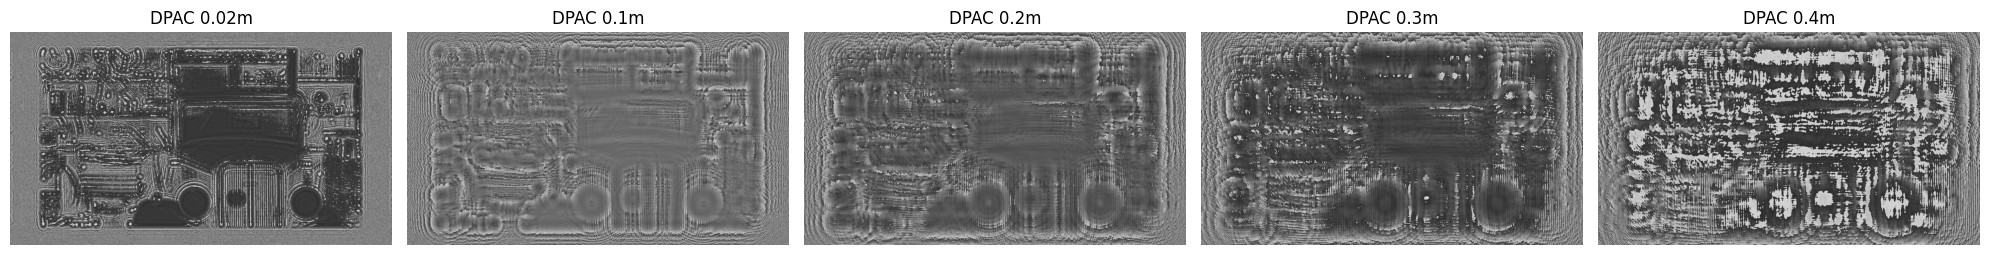

In [ ]:
visualization_title = [f'DPAC {z}m' for z in prop_dist]

dpac_pohs = []
for hologram in image_to_slm:
    dpac_poh, _, _ = double_phase_amplitude_coding(hologram)
    dpac_pohs.append(dpac_poh)

plt.figure(figsize=(20, 20))
for i, dpac_poh in enumerate(dpac_pohs):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(dpac_poh, cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

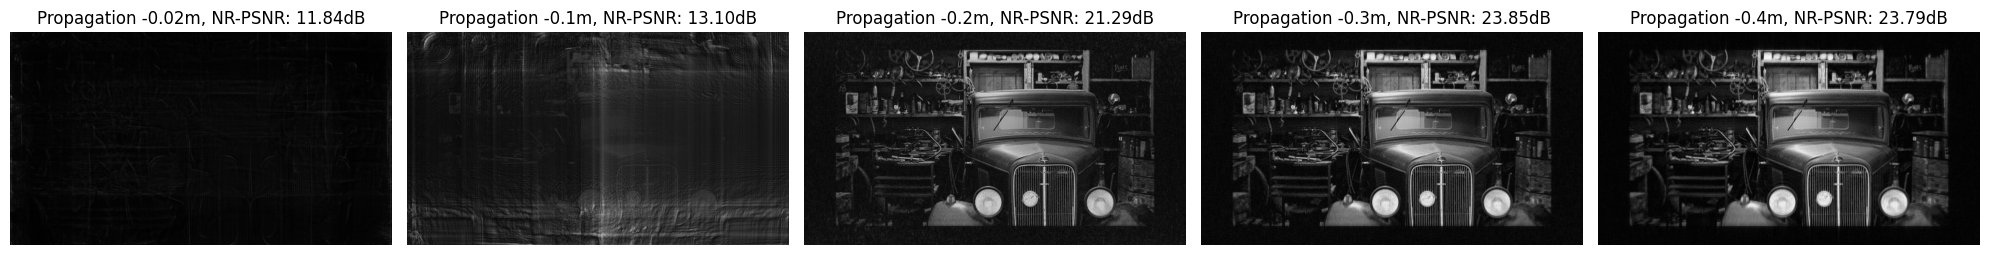

In [ ]:
img = np.abs(img)
psnrs = []
slm_to_image = []
for z, dpac_poh in zip(prop_dist, dpac_pohs):
    recon = propagation_blasm(np.exp(1j * dpac_poh), feature_size, wave_length, -z)

    recon = np.abs(recon)
    recon = (recon - np.amin(recon)) / (np.amax(recon) - np.amin(recon))
    
    slm_to_image.append(recon)
    psnrs.append(peak_signal_noise_ratio(img, recon))

visualization_title = [f'Propagation -{z}m, NR-PSNR: {psnr:.2f}dB' for psnr, z in zip(psnrs, prop_dist)]

plt.figure(figsize=(20, 20))
for i, image in enumerate(slm_to_image):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()